In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from dataset.dataloader import CINE2DT
from model.model_pytorch import CRNN_MRI
from utils import multicoil2single, compressed_sensing as cs
from utils.dnn_io import to_tensor_format, from_tensor_format
from trainer_dcrnn_test import prep_input
from torch.autograd import Variable
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'  # 指定使用 GPU 1 和 GPU 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [7]:
import torch

def r2c_5d_to_4d(x):
    # 检查输入是否为numpy数组，如果是，则转换为Tensor
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    
    # 假设x的形状为[batch_size, 2, height, width, channels]
    # 我们将第一个维度（大小为2）的实部和虚部分别取出
    re = x[:, 0, :, :, :]  # 实部
    im = x[:, 1, :, :, :]  # 虚部
    
    # 创建复数张量
    x_complex = torch.complex(re, im)
    
    # 返回四维张量，形状为[batch_size, height, width, channels]
    return x_complex

# 假设输入张量的形状为[2, 2, 192, 192, 18]
# 使用上面的函数将其转换为四维复数张量
input_tensor = torch.randn(2, 2, 192, 192, 18)
output_tensor = r2c_5d_to_4d(input_tensor)

print(f"Output tensor shape: {output_tensor.shape}")
print(f"Output tensor dtype: {output_tensor.dtype}")

# 使用torch.view_as_real将复数张量转换为实数张量
output_real_tensor = torch.view_as_real(output_tensor)

# 输出张量的形状应该是[batch_size, height, width, channels * 2]
# 因为复数张量的每个元素都由一个实部和虚部组成
print(f"Output real tensor shape: {output_real_tensor.shape}")
print(f"Output real tensor dtype: {output_real_tensor.dtype}")

# 只保留复数张量的实部
output_real_tensor = torch.real(output_tensor)
# 或者只保留复数张量的虚部
# output_real_tensor = torch.imag(output_tensor)
# 输出张量的形状仍然是[batch_size, height, width, channels]
print(f"Output real tensor shape: {output_real_tensor.shape}")
print(f"Output real tensor dtype: {output_real_tensor.dtype}")






Output tensor shape: torch.Size([2, 192, 192, 18])
Output tensor dtype: torch.complex64
Output real tensor shape: torch.Size([2, 192, 192, 18, 2])
Output real tensor dtype: torch.float32
Output real tensor shape: torch.Size([2, 192, 192, 18])
Output real tensor dtype: torch.float32


In [3]:
import torch
import yaml
import types

# def get_config():
#     """
#     从config_dcrnn.yaml文件中读取配置信息并返回
#     返回:
#     config (dict): 包含配置信息的字典，符合CRNN_MRI类初始化等所需的配置结构
#     """
#     config_path = "/nfs/zzy/code/k_gin_base/config_dcrnn.yaml"
#     with open(config_path, 'r') as file:
#         full_config = yaml.safe_load(file)

#     # 提取network部分中CRNN_MRI相关配置，假设其结构如你所述
#     network_config = full_config.get("network", {}).get("CRNN_MRI", {})
#     return network_config
class ConfigWrapper:
    def __init__(self, config_data):
        # 使用types.SimpleNamespace将字典转换为可通过属性访问的对象形式
        self.CRNN_MRI = types.SimpleNamespace(**config_data)


def get_config_model():
    """
    从config_dcrnn.yaml文件中读取配置信息并返回
    返回:
    config (ConfigWrapper): 包含配置信息的包装类实例，其CRNN_MRI属性对应包含模型初始化参数的字典，符合CRNN_MRI类初始化的配置结构期望
    """
    config_path = "/nfs/zzy/code/k_gin_base/config_dcrnn.yaml"
    with open(config_path, 'r') as file:
        full_config = yaml.safe_load(file)

    # 提取network部分中CRNN_MRI相关配置，假设其结构如你所述
    network_config = full_config.get("network", {}).get("CRNN_MRI", {})
    return ConfigWrapper(network_config)

def get_config_data_test():
    """
    从config_dcrnn.yaml文件中读取配置信息并返回
    返回:
    config (dict): 完整的配置信息字典，符合各个类实例化及相关功能对配置的需求
    """
    config_path = "/nfs/zzy/code/k_gin_base/config_dcrnn.yaml"
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# 定义函数来加载训练好的模型以及对应的测试数据集
def load_model(model_path, config):
    """
    加载训练好的模型
    参数:
    model_path (str): 模型文件（.pth）的路径
    config: 配置参数，符合CRNN_MRI类构造函数要求的格式
    返回:
    model (torch.nn.Module): 加载好权重的模型对象
    """
    model = CRNN_MRI(config)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model

class DataConfigWrapper:
    def __init__(self, data_dict):
        for key, value in data_dict.items():
            setattr(self, key, value)
            
def load_test_data(config):
    """
    加载测试数据集
    返回:
    test_loader (DataLoader): 测试数据的数据加载器
    """
    # test_ds = CINE2DT(config=None, mode='val')  # 这里的config参数需根据实际情况传入正确配置，暂时设为None示例
    # test_ds = CINE2DT(config=config.data, mode='val')
    wrapped_data_config = DataConfigWrapper(config)
    # test_ds = CINE2DT(config=config, mode='val')
    # 然后将包装后的配置对象传入CINE2DT类构造函数
    test_ds = CINE2DT(config=wrapped_data_config, mode='val')
    test_loader = DataLoader(dataset=test_ds, num_workers=2, drop_last=False, batch_size=2, shuffle=False)
    return test_loader

In [4]:
# # 定义函数用于显示原始图片、重建图片以及它们之间的差异（例如计算差值或者使用其他对比指标来可视化差异，这里简单展示计算差值的方式）：
# def display_images(original_image, reconstructed_image):
#     """
#     显示原始图片、重建图片以及它们的差异图像
#     参数:
#     original_image (torch.Tensor 或 np.ndarray): 原始图片数据
#     reconstructed_image (torch.Tensor 或 np.ndarray): 重建图片数据
#     """
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#     # 显示原始图片
#     axes[0].imshow(original_image.squeeze().cpu().numpy(), cmap='gray')
#     axes[0].set_title('Original Image')
#     axes[0].axis('off')

#     # 显示重建图片
#     axes[1].imshow(reconstructed_image.squeeze().cpu().numpy(), cmap='gray')
#     axes[1].set_title('Reconstructed Image')
#     axes[1].axis('off')

#     # 计算并显示差异图像（简单计算差值）
#     diff_image = np.abs(original_image.squeeze().cpu().numpy() - reconstructed_image.squeeze().cpu().numpy())
#     axes[2].imshow(diff_image, cmap='gray')
#     axes[2].set_title('Difference Image')
#     axes[2].axis('off')

#     plt.show()
def display_images(original_image, reconstructed_image):
    """
    显示原始图片、重建图片及其差异。
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # # 转换为适合显示的格式（取复数模值）
    # original_image_display = np.abs(original_image.squeeze().cpu().numpy())
    # reconstructed_image_display = np.abs(reconstructed_image.squeeze().cpu().numpy())
    # difference_image_display = np.abs(original_image_display - reconstructed_image_display)
    # 保证输入数据为 NumPy 格式
    original_image = original_image.cpu().numpy()
    reconstructed_image = reconstructed_image.cpu().numpy()

    # # 确保两个数据的形状一致（取批次中第一张图像）
    # original_image_display = np.abs(original_image[0])  # 假设取第一张图片
    # reconstructed_image_display = np.abs(reconstructed_image[0])  # 假设取第一张图片
    # 提取第一个 batch 的第一个切片
    original_image_display = np.abs(original_image[0, 0])  # [192, 192]
    reconstructed_image_display = np.abs(reconstructed_image[0, 0])  # [192, 192]

    # 差异图片
    difference_image_display = np.abs(original_image_display - reconstructed_image_display)

    # 显示原始图片
    axes[0].imshow(original_image_display, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # 显示重建图片
    axes[1].imshow(reconstructed_image_display, cmap='gray')
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')

    # 显示差异图片
    axes[2].imshow(difference_image_display, cmap='gray')
    axes[2].set_title('Difference Image')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

data_config: {'train_subjs': '/nfs/zzy/data/k_gin_data/k_cine_multicoil_training.npy', 'train_maps': '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_training.npy', 'val_subjs': '/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy', 'val_maps': '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy', 'mask_root': '/nfs/zzy/code/k_gin_base/masks/VISTA/e_192x18_acs4_R4.mat', 'data_root': '/nfs/zzy/data/k_gin_data', 'mask_pattern': 'VISTA', 'acc_rate': [4], 'dtype': 'complex128', 'training_patch_time': 16, 'only_infer': False}


/tmp/ipykernel_339419/239937898.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


prep_input-mask-shape: (2, 18, 192, 192)
prep_input-mask-dtype: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex64
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex64
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float32
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_

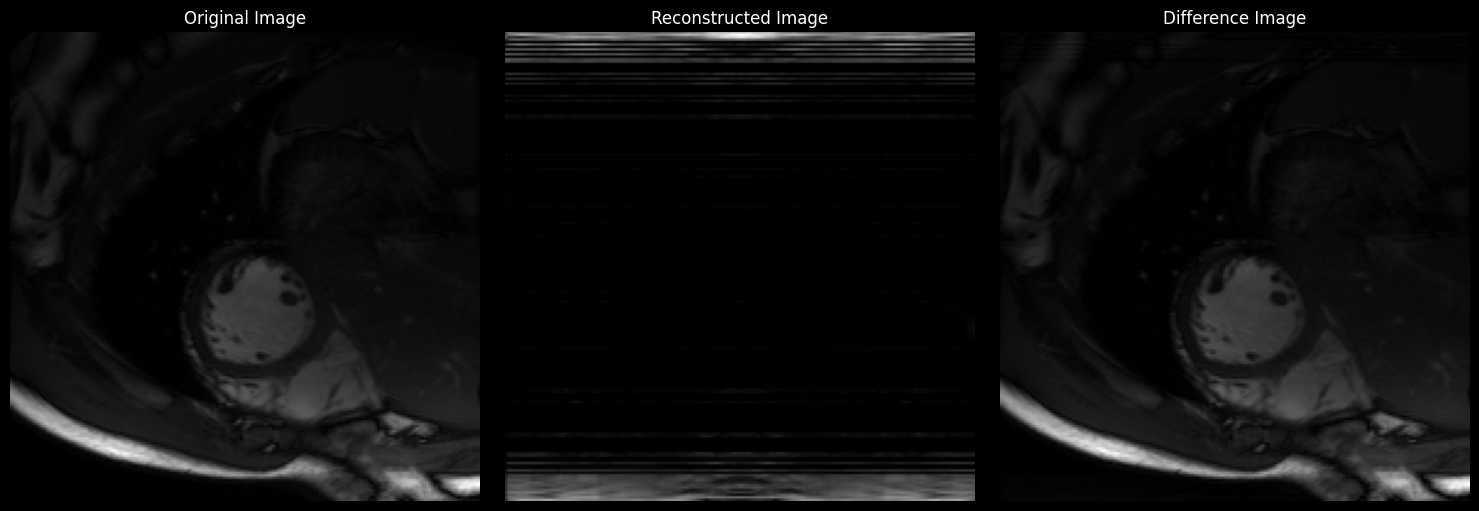

prep_input-mask-shape: (2, 18, 192, 192)
prep_input-mask-dtype: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex64
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex64
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float32
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_

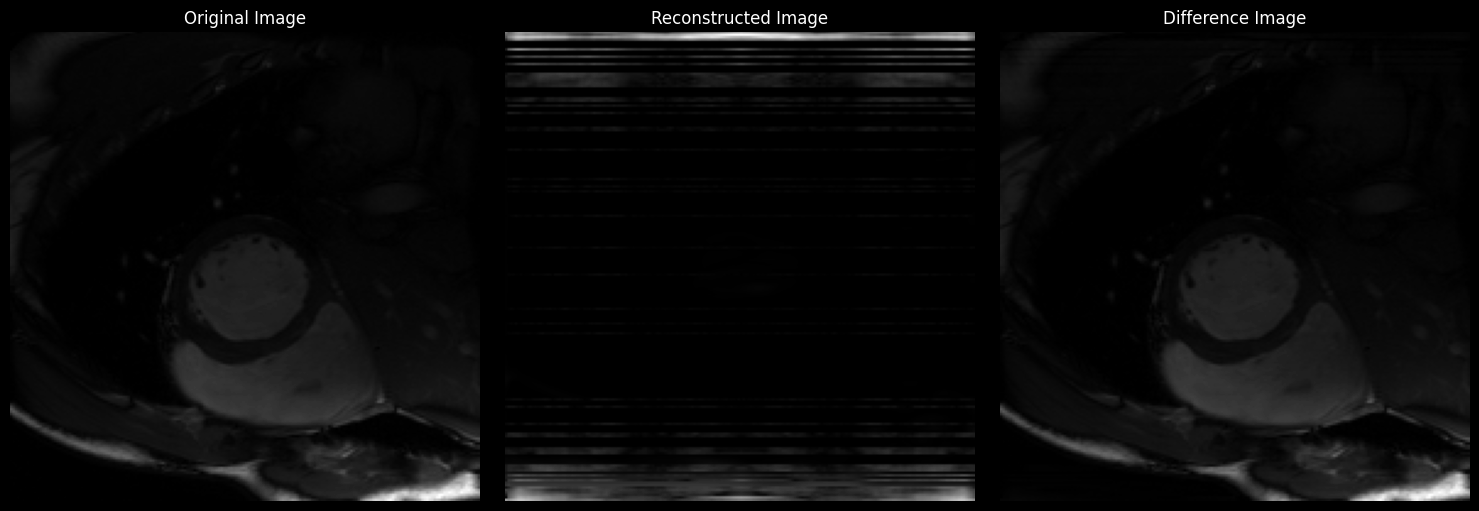

prep_input-mask-shape: (2, 18, 192, 192)
prep_input-mask-dtype: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex64
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex64
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float32
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_

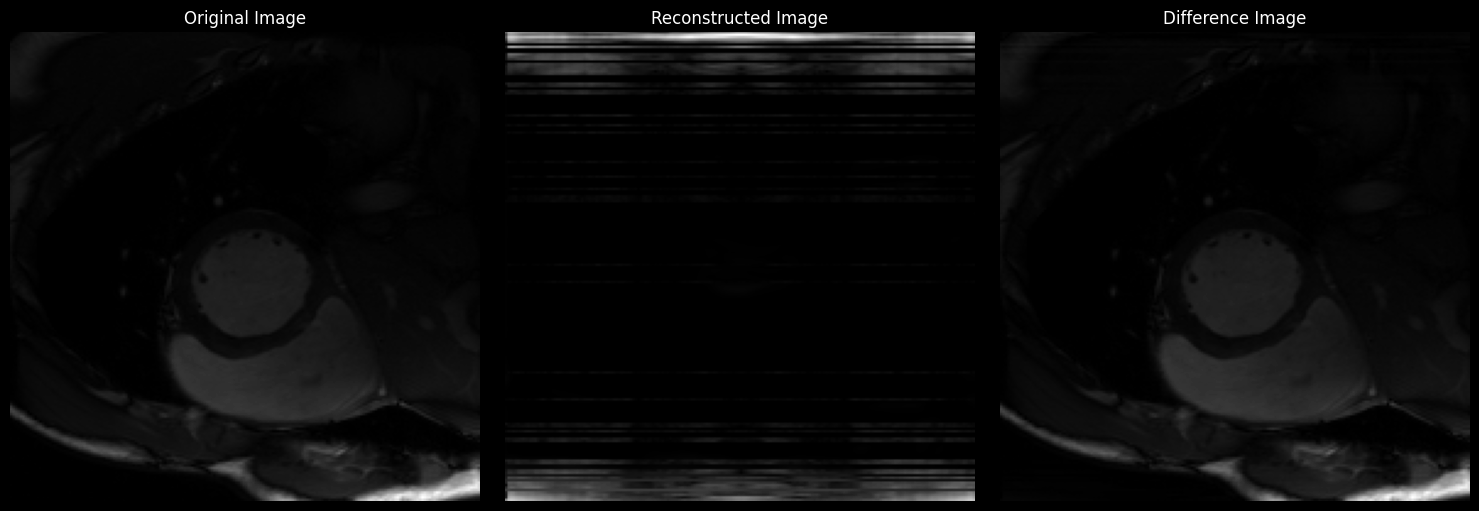

prep_input-mask-shape: (2, 18, 192, 192)
prep_input-mask-dtype: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex64
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex64
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float32
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_

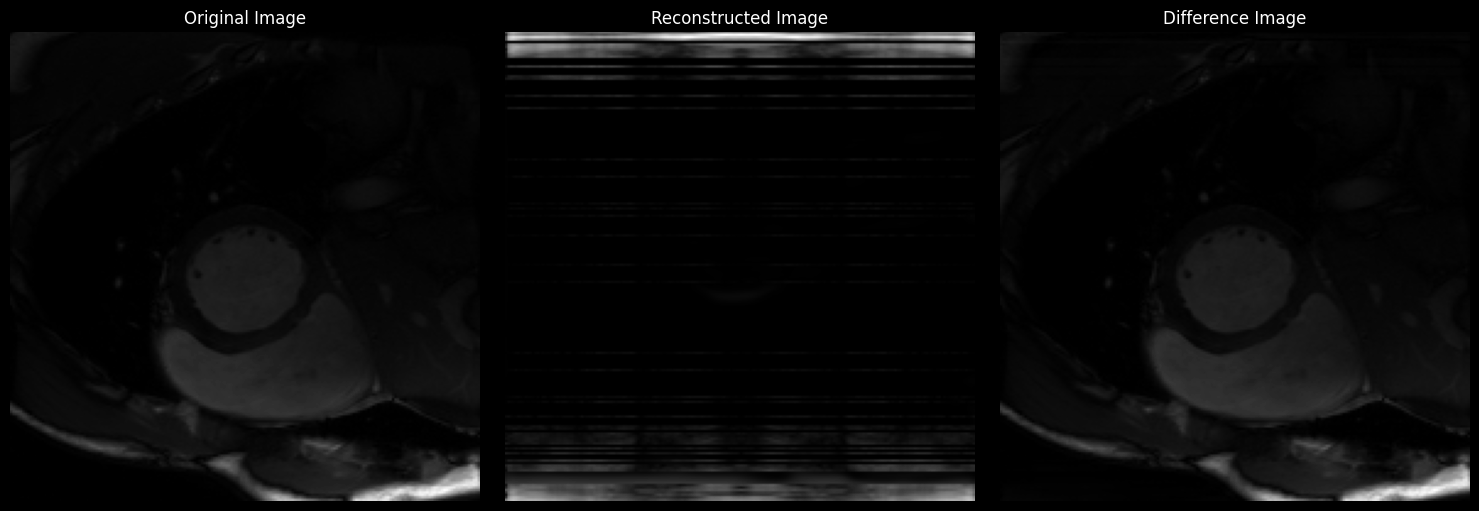

prep_input-mask-shape: (2, 18, 192, 192)
prep_input-mask-dtype: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex64
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex64
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float32
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_format-x-dtype-2: float64
to_tensor_format-x-shape-1: (2, 192, 192, 18)
to_tensor_format-x-dtype-1: complex128
dnn_io-c2r-x-shape: (2, 192, 192, 18)
dnn_io-c2r-x-dtype: complex128
to_tensor_format-x-shape-2: (2, 2, 192, 192, 18)
to_tensor_

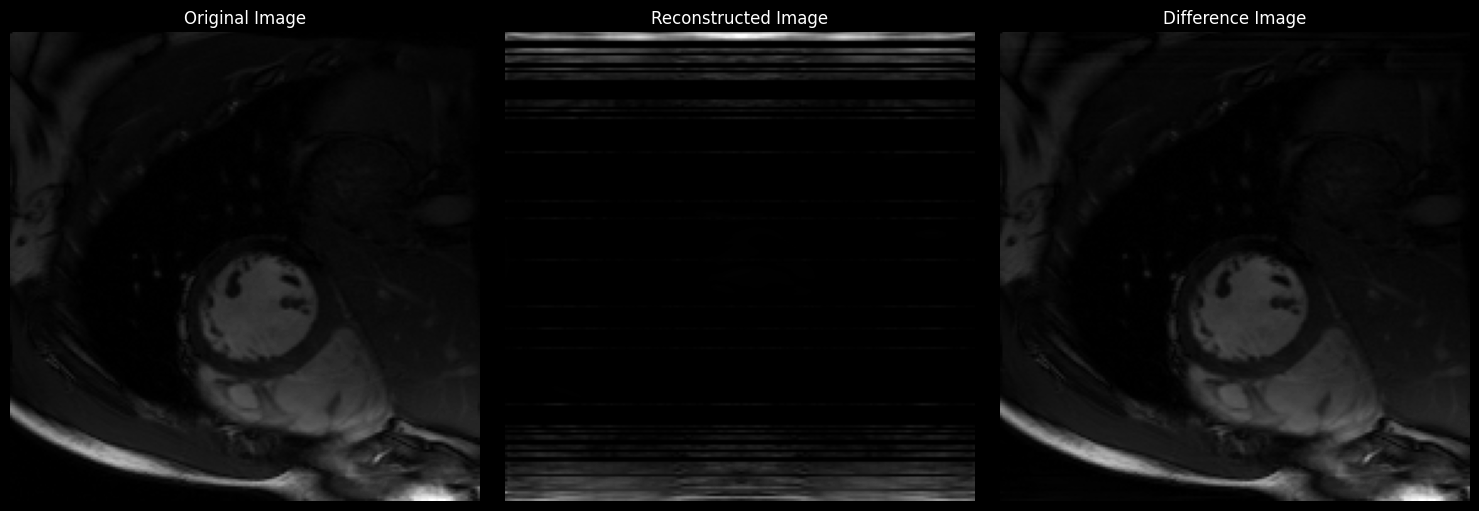

In [5]:
# 主逻辑代码来调用上述函数，实现加载模型、数据，并进行图片显示
# 模型文件路径，替换为你实际保存的模型文件路径
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn/model_101.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_241.pth'
# model_path = '/nfs/zzy/code/k_gin_base/models/dc_rnn_test/final_model.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_300.pth'
model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test_3/model_161.pth'
model_config  = get_config_model()
data_test_config = get_config_data_test()
data_config = data_test_config.get('data', {})  # 提取data部分配置信息，若不存在则返回空字典
print('data_config:',data_config)
model = load_model(model_path,model_config)
test_loader = load_test_data(data_config)
# test_loader = load_test_data(data_test_config)
# 将模型加载到相同设备
model = model.to(device)

for i, (kspace, coilmaps, sampling_mask) in enumerate(test_loader):
    if i >= 5:  # 只显示前5个示例图片，可根据需要调整数量
        break
    ref_kspace, ref_img = multicoil2single(kspace, coilmaps)
    ref_img = ref_img.squeeze()  # 去除批次维度

    # 假设这里的处理逻辑和训练时的prep_input函数等保持一致，进行必要的数据预处理
    im_und, k_und, mask, im_gnd = prep_input(ref_img, acc=4.0)  # acc参数需根据实际训练情况传入正确值
    # im_u = torch.from_numpy(to_tensor_format(im_und)).unsqueeze(0).type(torch.FloatTensor)  # 添加批次维度
    # k_u = torch.from_numpy(to_tensor_format(k_und)).unsqueeze(0).type(torch.FloatTensor)
    # mask = torch.from_numpy(to_tensor_format(mask)).unsqueeze(0).type(torch.FloatTensor)
    # 数据也需要移到相同设备
    im_u = Variable(im_und.type(Tensor)).to(device)
    k_u = Variable(k_und.type(Tensor)).to(device)
    mask = Variable(mask.type(Tensor)).to(device)
    gnd = Variable(im_gnd.type(Tensor)).to(device)

    with torch.no_grad():
        reconstructed_image = model(im_u, k_u, mask, test=True)
    # reconstructed_image-shape: torch.Size([2, 2, 192, 192, 18])
    # ref_img-shape: torch.Size([2, 18, 192, 192])
    print('reconstructed_image-shape-1:',reconstructed_image.shape)
    print('ref_img-shape:',ref_img.shape)
    # 对 reconstructed_image 取模值，合并通道
    reconstructed_image = torch.sqrt(reconstructed_image[:, 0, ...] ** 2 + reconstructed_image[:, 1, ...] ** 2)  # [2, 192, 192, 18]

    # 转置 reconstructed_image 的维度，匹配 ref_img 的形状
    reconstructed_image = reconstructed_image.permute(0, 3, 1, 2)  # [2, 18, 192, 192]
    print('reconstructed_image-shape-2:',reconstructed_image.shape)
    display_images(ref_img, reconstructed_image.squeeze())